In [1]:
import os
import sys
import json
import pickle

from embedding import BertHuggingface

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import functools

import numpy as np
import math
import random
import scipy

import plotting
import utils
import yaml

2025-08-21 15:59:11.738657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755784751.753588   33770 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755784751.757663   33770 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755784751.770117   33770 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755784751.770134   33770 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755784751.770136   33770 computation_placer.cc:177] computation placer alr

In [28]:
CONFIG_CBM = 'configs/performance_cbm/emb.json'
CONFIG_PIE = 'configs/performance_pie/emb.json'#, 'configs/performance_pie/deepseek.json', 'configs/performance_pie/llama.json']

CONFIG_TRANSFER = 'configs/concept_transfer/emb.json'

# default parameters
CBM_LAMBDA = 0.5
N_CONCEPTS_UNSUP = 100
PIE_METHOD = 'bias_space'
PIE_DR_METHOD = 'pca'
PIE_REMOVE = True

In [29]:
def load_results(config_file, concept_filename):
    print('load %s' % config_file)
    with open(config_file, 'r') as f:
        config = json.load(f)

    results = pd.read_csv('../'+config['results_dir']+concept_filename)
    return config, results

cfg_pie, results_pie = load_results(CONFIG_PIE, 'pie_concept_results.csv')
cfg_cbm, results_cbm = load_results(CONFIG_CBM, 'cbm_concept_results.csv')
cfg_transfer, results_transfer = load_results(CONFIG_TRANSFER, 'cbm_transfer_results.csv')

load configs/performance_pie/emb.json
load configs/performance_cbm/emb.json
load configs/concept_transfer/emb.json


In [30]:
results_transfer.columns

Index(['dataset (train)', 'dataset (test)', 'model', 'model type',
       'architecture', 'method', 'pooling', 'classifier',
       'clf hidden size factor', 'emb size', 'protected concepts',
       'other concepts', 'lambda', 'optimizer', 'lr', 'loss', 'group (train)',
       'group (test)', 'Pearson R', 'pvalue', 'PR-AUC'],
      dtype='object')

In [131]:
# shared test groups
groups_test = set(results_pie_concept['group (test)'])

# adapt cbm columns
res_cbm = results_cbm.copy()
res_cbm = res_cbm[res_cbm['group'].isin(groups_test)]
res_cbm = res_cbm.rename(columns={'group': 'group (test)'})
res_cbm = res_cbm[res_cbm['lambda'] == CBM_LAMBDA]
res_cbm = res_cbm[res_cbm['other concepts'] == N_CONCEPTS_UNSUP]
res_cbm = res_cbm.drop(columns=['lambda'])
res_cbm = res_cbm.rename(columns={'dataset': 'dataset (train)'})
res_cbm['dataset (test)'] = res_cbm['dataset (train)']
res_cbm['group (train)'] = res_cbm['group (test)']

# adapt pie columns
res_pie = results_pie.copy()
res_cbm = res_cbm.rename(columns={'group (pie)': 'group (train)'})
res_pie = res_pie[res_pie['other concepts'] == N_CONCEPTS_UNSUP]
res_pie = res_pie[res_pie['method protected'] == PIE_METHOD]
res_pie = res_pie[res_pie['method unsupervised'] == PIE_DR_METHOD]
res_pie = res_pie[res_pie['remove protected'] == PIE_REMOVE]
res_pie = res_pie.drop(columns=['method protected'])
res_pie = res_pie.drop(columns=['method unsupervised'])
res_pie = res_pie.drop(columns=['remove protected'])
res_pie = res_pie.rename(columns={'dataset': 'dataset (test)'})
res_pie['dataset (train)'] = ''

# adapt transfer columns
res_transfer = results_transfer.copy()
res_transfer = res_transfer[res_transfer['lambda'] == CBM_LAMBDA]
res_transfer = res_transfer[res_transfer['other concepts'] == N_CONCEPTS_UNSUP]
res_transfer = res_transfer.drop(columns=['lambda'])
res_transfer['method'] = 'cbm (transfer)'

# merge concept results
res_concept = pd.concat([res_cbm, res_pie, res_transfer])
res_concept = res_concept.reset_index()
res_concept

,index,dataset (train),model,model type,architecture,method,pooling,classifier,clf hidden size factor,emb size,...,loss,group (test),Pearson R,pvalue,PR-AUC,Epochs,concepts,dataset (test),group (train),group (pie)
0,2625,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,1536,...,BCEWithLogitsLoss,white,0.184728,2.181270e-37,0.176892,15,../artifacts/pie_cbm_predictions/20250728_0833...,sbic,white,NaN
1,2626,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,1536,...,BCEWithLogitsLoss,black,0.801445,0.000000e+00,0.929389,15,../artifacts/pie_cbm_predictions/20250728_0833...,sbic,black,NaN
2,2627,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,1536,...,BCEWithLogitsLoss,asian,0.434121,1.474854e-215,0.597063,15,../artifacts/pie_cbm_predictions/20250728_0833...,sbic,asian,NaN
3,2629,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,1536,...,BCEWithLogitsLoss,latin-american,0.285384,7.114832e-89,0.541591,15,../artifacts/pie_cbm_predictions/20250728_0833...,sbic,latin-american,NaN
4,2630,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,1536,...,BCEWithLogitsLoss,hispanic,0.410667,6.711819e-191,0.588253,15,../artifacts/pie_cbm_predictions/20250728_0833...,sbic,hispanic,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,343,stereoset,text-embedding-3-large,text-embedding-3,embedder,cbm (transfer),NaN,linear,-1.0,3072,...,<class 'torch.nn.modules.loss.CrossEntropyLoss'>,male,0.774771,0.000000e+00,0.933946,NaN,NaN,crows_pairs,male,NaN
1852,344,stereoset,text-embedding-3-large,text-embedding-3,embedder,cbm (transfer),NaN,linear,-1.0,3072,...,<class 'torch.nn.modules.loss.CrossEntropyLoss'>,female,0.819099,0.000000e+00,0.906503,NaN,NaN,crows_pairs,female,NaN
1853,345,stereoset,text-embedding-3-large,text-embedding-3,embedder,cbm (transfer),NaN,linear,-1.0,3072,...,<class 'torch.nn.modules.loss.CrossEntropyLoss'>,christian,0.669928,0.000000e+00,0.879375,NaN,NaN,crows_pairs,christian,NaN
1854,346,stereoset,text-embedding-3-large,text-embedding-3,embedder,cbm (transfer),NaN,linear,-1.0,3072,...,<class 'torch.nn.modules.loss.CrossEntropyLoss'>,muslim,0.630063,0.000000e+00,0.998001,NaN,NaN,crows_pairs,muslim,NaN


In [132]:
# categorizing protected groups
def group2attr(group):
    if group in ['white', 'black', 'asian', 'latin-american', 'hispanic', 'middle eastern', 'african', 'hispanic/latino', 'middle east', 'south east asian', 'latino', 'european', 'aa']:
        return 'ethnicity'
    if group in ['male', 'female', 'trans', 'lgbtq+', 'transgender']:
        return 'gender'
    if group in ['homosexual', 'bisexual', 'heterosexual', 'homosexual_gay_or_lesbian']:
        return 'sex_or'
    if group in ['christian', 'muslim/islam', 'muslim', 'jewish']:
        return 'religion'
    if group in ['disability', 'intellectual_or_learning_disability', 'mental disability', 'mental illness', 'mental illness/ disorder', 'physical disability', 'physical_disability', 'psychiatric_or_mental_illness']:
        return 'disability'
    return 'n/a'

res_concept['attribute'] = ''
for idx in res_concept.index:
    res_concept.loc[idx, 'attribute'] = group2attr(res_concept.loc[idx,'group (test)'])

## Compare results of Pie, CBM and transfer-CBM

In [133]:
def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0):
    # mark 0 with hline
    #ax.hlines(y=0, xmin=-1, xmax=6, linewidth=0.5, color='black')
    ax.axhline(y=0, color="grey", linestyle="--", linewidth=1)
    ax.axhline(y=1, color="grey", linestyle="--", linewidth=1)
    
    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        sns.boxplot(data=res_dataset, x=xcol, y=ycol, ax=ax)


    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=15)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=15)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    legend = ax.legend(fontsize=14)
    if remove_legend:
        legend.remove()

def multipot(results, subplot_col, xcol, ycol, huecol, title=None, remove_legend=False, savefile=None):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(7*len(subplot_choices), 6))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0), ymin=-0.05, ymax=1.05)
    if title is not None:
        plt.suptitle(title)
    
    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

In [134]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res


In [166]:
datasets = list(set(res_concept.loc[:,'dataset (test)']))
target_col = 'PR-AUC'
groups = list(set(res_concept['group (test)']))
methods = list(set(res_concept['method']))

### High-level comparison

PIE vs. CBM vs. CBM-transfer

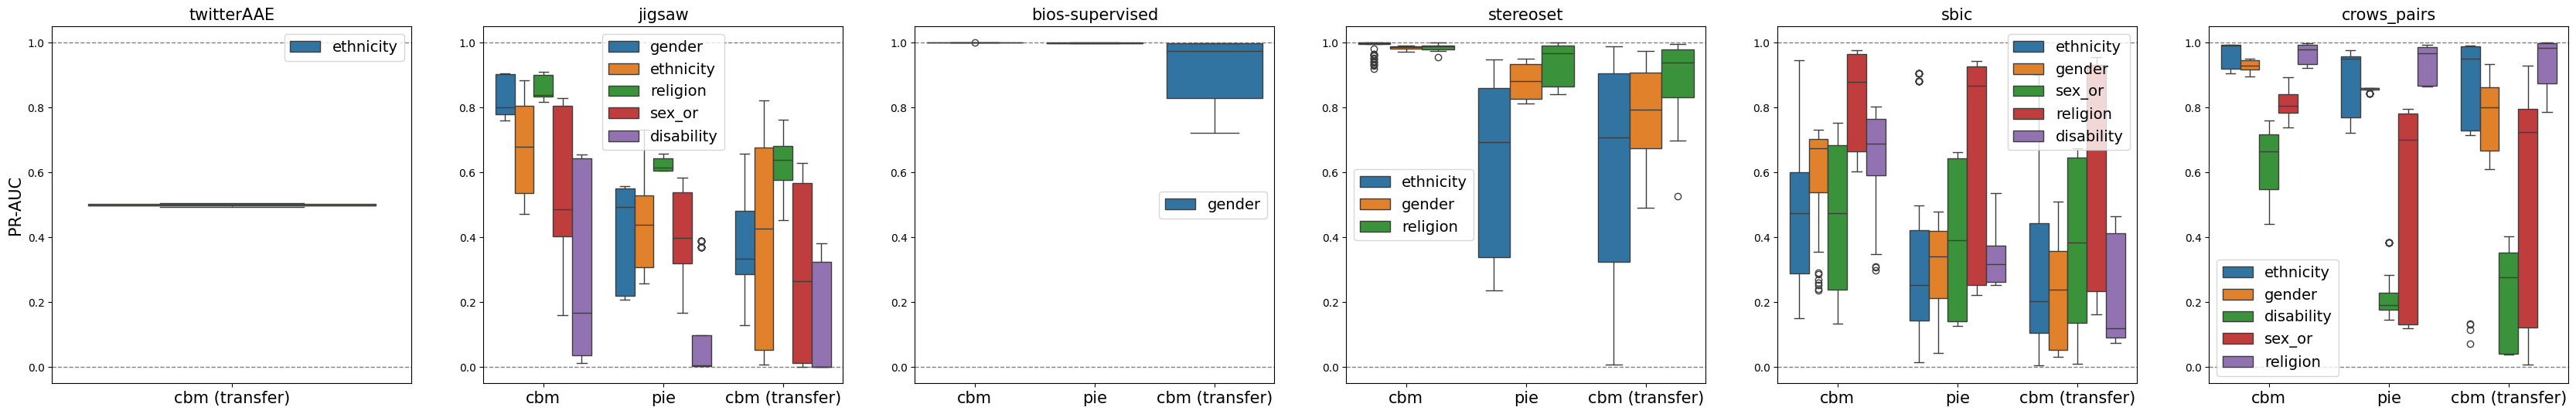

In [136]:
multipot(res_concept, subplot_col='dataset (test)', xcol='method', ycol='PR-AUC', huecol='attribute', remove_legend=False)

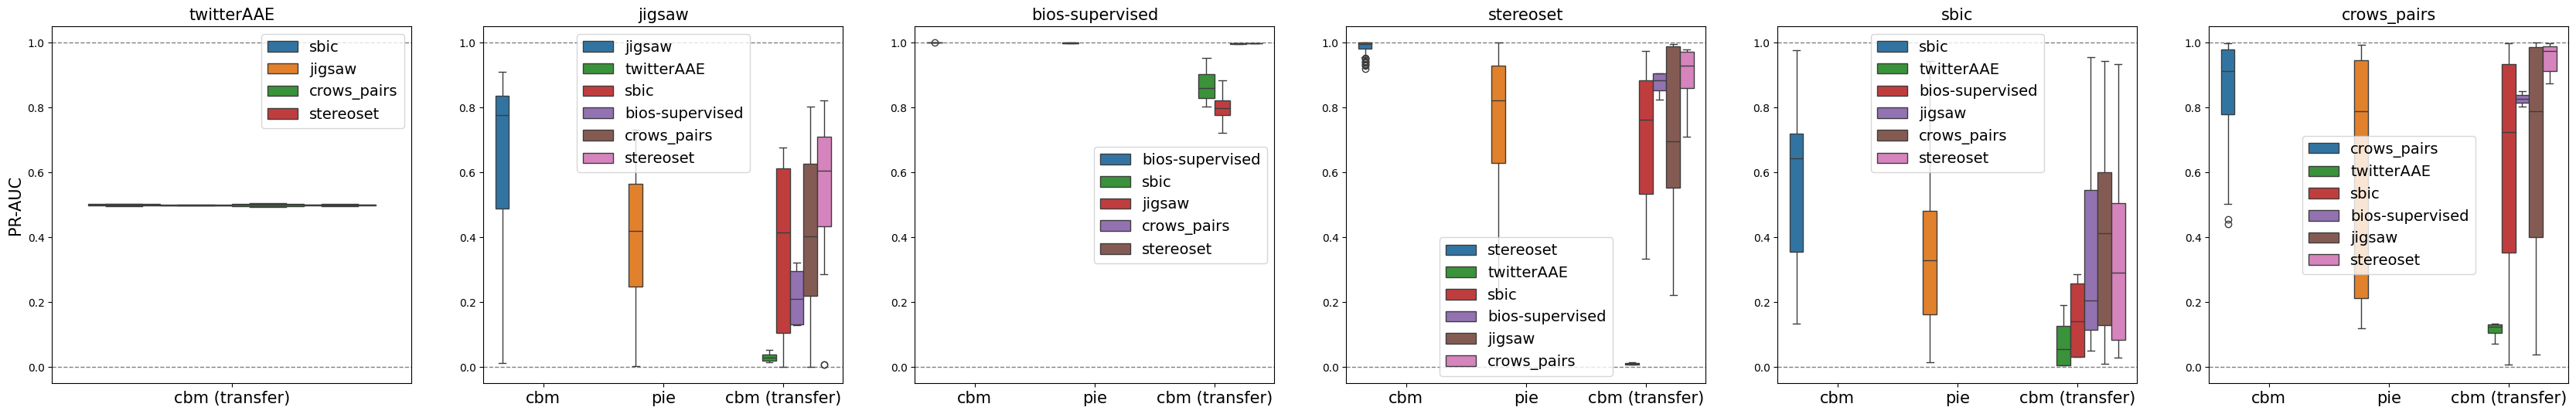

In [137]:
multipot(res_concept, subplot_col='dataset (test)', xcol='method', ycol='PR-AUC', huecol='dataset (train)', remove_legend=False)

In [138]:
# table
res_concept_ = aggregate_results(res_concept, sel_cols=['method', 'dataset (test)'], target_col=target_col)
table = res_concept_.pivot(index="method", columns="dataset (test)", values="PR-AUC")
table

dataset (test),bios-supervised,crows_pairs,jigsaw,sbic,stereoset,twitterAAE
method,,,,,,
cbm,0.999952,0.857238,0.637377,0.575630,0.987057,NaN
cbm (transfer),0.916476,0.686156,0.386563,0.356101,0.717590,0.499669
pie,0.999021,0.646431,0.387208,0.372076,0.727994,NaN


In [139]:
# to latex
latex_code = table.to_latex(float_format="%.3f")  # z. B. auf 3 Nachkommastellen runden
print(latex_code)

\begin{tabular}{lrrrrrr}
\toprule
dataset (test) & bios-supervised & crows_pairs & jigsaw & sbic & stereoset & twitterAAE \\
method &  &  &  &  &  &  \\
\midrule
cbm & 1.000 & 0.857 & 0.637 & 0.576 & 0.987 & NaN \\
cbm (transfer) & 0.916 & 0.686 & 0.387 & 0.356 & 0.718 & 0.500 \\
pie & 0.999 & 0.646 & 0.387 & 0.372 & 0.728 & NaN \\
\bottomrule
\end{tabular}



In [174]:
res_concept_ = aggregate_results(res_concept, sel_cols=['group (test)', 'method'], target_col=target_col)

# ranking methods per group
count_1st = {method: 0 for method in methods}
count_2nd = {method: 0 for method in methods}
groups_1st = {method: [] for method in methods}
groups_2nd = {method: [] for method in methods}

for group in groups:
    group_res = res_concept_[res_concept_['group (test)'] == group]
    ids = np.argsort(group_res[target_col])[::-1] # best first
    methods = list(group_res['method'])
    methods_ranked = [methods[i] for i in ids]
    count_1st[methods_ranked[0]] += 1
    groups_1st[methods_ranked[0]].append(group)

    if len(methods_ranked) == 1:
        continue
        
    count_2nd[methods_ranked[1]] += 1
    groups_2nd[methods_ranked[1]].append(group)

In [178]:
d = {'ranked 1st': count_1st, 'ranked 2nd': count_2nd, 'groups (1st)': groups_1st, 'groups (2nd)': groups_2nd}
df = pd.DataFrame(d)
df

,ranked 1st,ranked 2nd,groups (1st),groups (2nd)
cbm,32,1,"[muslim, hispanic, christian, mental illness, ...",[trans]
cbm (transfer),1,10,[aa],"[muslim, hispanic, jewish, heterosexual, afric..."
pie,1,22,[trans],"[christian, mental illness, physical_disabilit..."


In [180]:
latex_code = df.to_latex(float_format="%.3f")  # z. B. auf 3 Nachkommastellen runden
print(latex_code)

\begin{tabular}{lrrll}
\toprule
 & ranked 1st & ranked 2nd & groups (1st) & groups (2nd) \\
\midrule
cbm & 32 & 1 & ['muslim', 'hispanic', 'christian', 'mental illness', 'jewish', 'physical_disability', 'mental illness/ disorder', 'heterosexual', 'hispanic/latino', 'south east asian', 'physical disability', 'african', 'middle east', 'black', 'white', 'female', 'european', 'lgbtq+', 'homosexual', 'homosexual_gay_or_lesbian', 'latin-american', 'bisexual', 'latino', 'psychiatric_or_mental_illness', 'muslim/islam', 'male', 'transgender', 'intellectual_or_learning_disability', 'disability', 'mental disability', 'asian', 'middle eastern'] & ['trans'] \\
cbm (transfer) & 1 & 10 & ['aa'] & ['muslim', 'hispanic', 'jewish', 'heterosexual', 'african', 'middle east', 'european', 'homosexual', 'homosexual_gay_or_lesbian', 'latin-american'] \\
pie & 1 & 22 & ['trans'] & ['christian', 'mental illness', 'physical_disability', 'mental illness/ disorder', 'hispanic/latino', 'south east asian', 'physical

In [177]:
groups_2nd

{'cbm': ['trans'],
 'cbm (transfer)': ['muslim',
  'hispanic',
  'jewish',
  'heterosexual',
  'african',
  'middle east',
  'european',
  'homosexual',
  'homosexual_gay_or_lesbian',
  'latin-american'],
 'pie': ['christian',
  'mental illness',
  'physical_disability',
  'mental illness/ disorder',
  'hispanic/latino',
  'south east asian',
  'physical disability',
  'black',
  'white',
  'female',
  'lgbtq+',
  'bisexual',
  'latino',
  'psychiatric_or_mental_illness',
  'muslim/islam',
  'male',
  'transgender',
  'intellectual_or_learning_disability',
  'disability',
  'mental disability',
  'asian',
  'middle eastern']}

### Compare transfer cases
to highlight where transfer was most/ least successful (vs. regular pie/cbm)

In [116]:
res_pie_ = res_concept[res_concept['method'] == 'pie']
res_cbm_ = res_concept[res_concept['method'] != 'pie']


def create_heatmap(res_cbm, res_pie, target_col='PR-AUC', figsize=8, title=''):
    res_cbm_agg = aggregate_results(res_cbm, sel_cols=['dataset (train)', 'dataset (test)'], target_col=target_col)
    res_pie_agg = aggregate_results(res_pie, sel_cols=['dataset (test)'], target_col=target_col)
    
    cross_dataset_cbm_scores = np.zeros((len(datasets),len(datasets)))
    for i, dataset_train in enumerate(datasets):
        for j, dataset_test in enumerate(datasets):
            res = res_cbm_agg[(res_cbm_agg["dataset (train)"] == dataset_train) & (res_cbm_agg["dataset (test)"] == dataset_test)]
            if len(res) == 0:
                continue
            cross_dataset_cbm_scores[i][j] = res.iloc[0][target_col]
    
    pie_scores = np.zeros((1, len(datasets)))
    for j, dataset_test in enumerate(datasets):
        res = res_pie_agg[res_pie_agg["dataset (test)"] == dataset_test]
        if len(res) == 0:
            continue
        pie_scores[0,j] = res.iloc[0][target_col]

    data = np.vstack([cross_dataset_cbm_scores, pie_scores])
    n = len(datasets)
    
    # Heatmap zeichnen
    plt.figure(figsize=(figsize,figsize))
    sns.heatmap(data, annot=True, cmap="viridis", cbar=True)
    
    # Achsen-Labels anpassen
    plt.xticks(np.arange(0.5, n+0.5), labels=datasets, rotation=90)
    plt.yticks(np.arange(0.5, n+1.5), labels=['CBM (%s)' % d for d in datasets] + ["PIE"], rotation=0)

    plt.title(title)
    plt.ylabel('concept model')
    plt.xlabel('test datasets')
    
    plt.show()

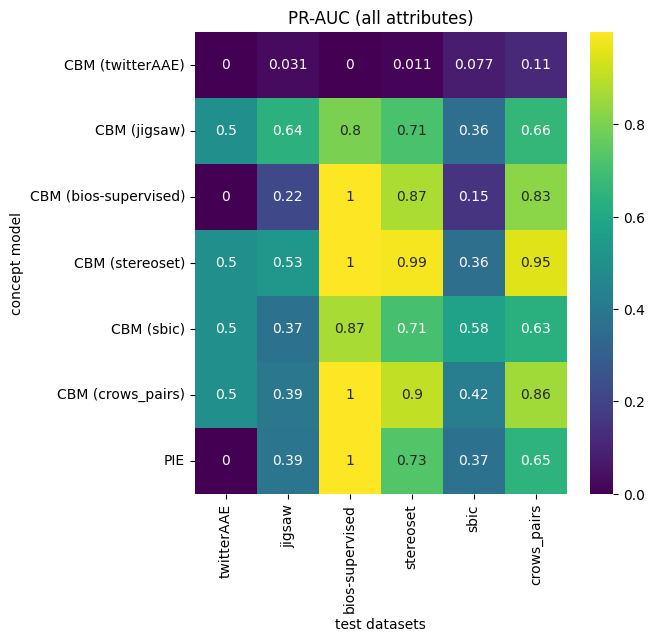

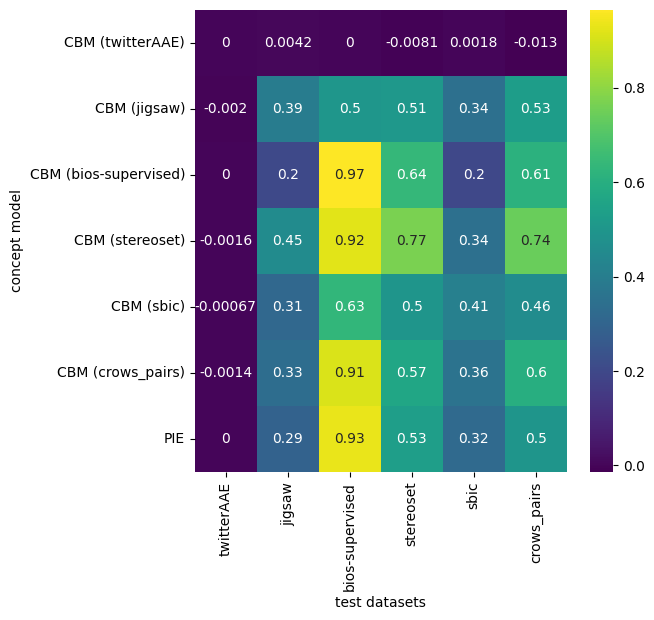

In [117]:
create_heatmap(res_cbm_, res_pie_, target_col='PR-AUC', title='PR-AUC (all attributes)', figsize=6)
create_heatmap(res_cbm_, res_pie_, target_col='Pearson R', figsize=6)

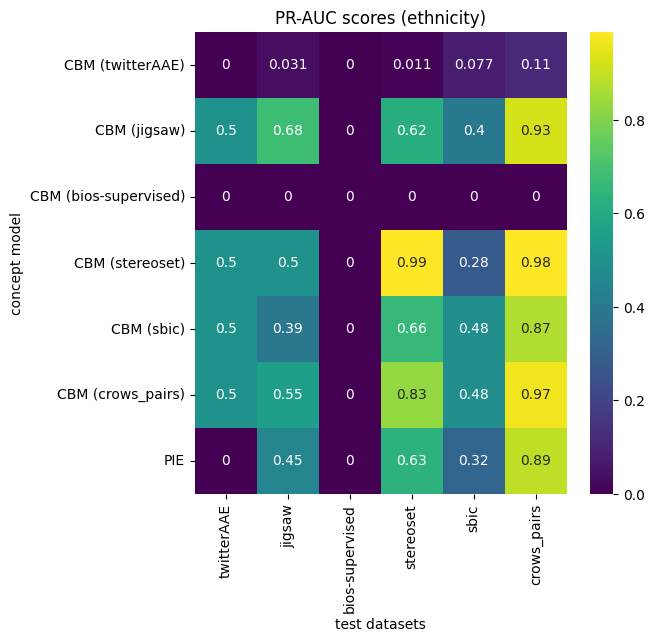

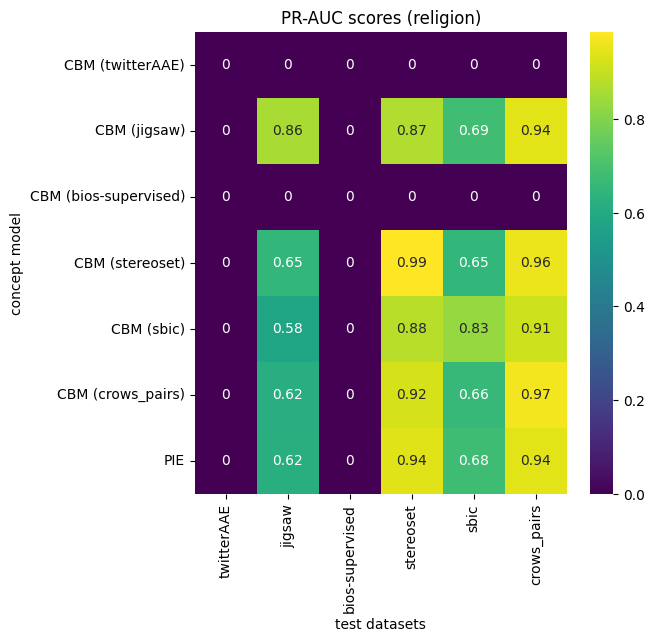

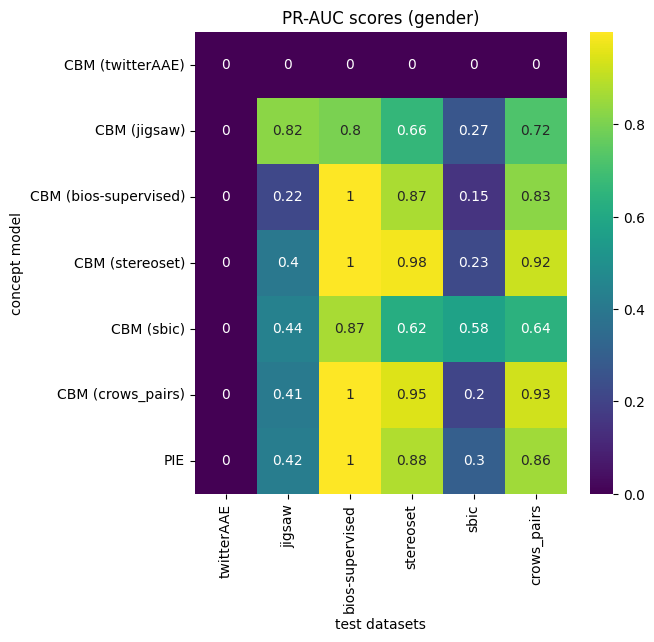

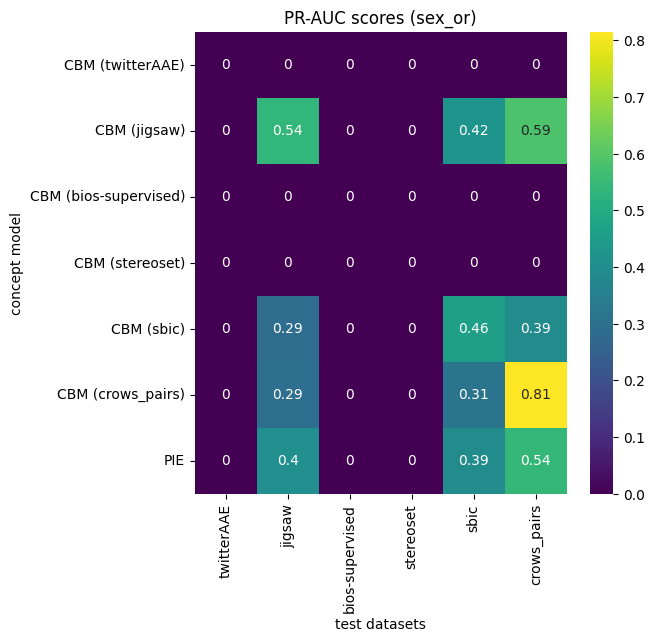

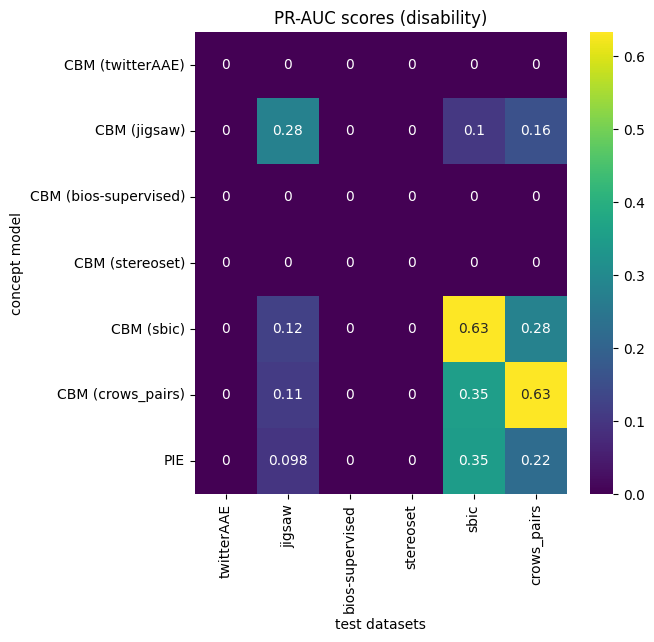

In [118]:
attributes = set(res_cbm_.loc[:,'attribute'])

for attr in attributes:
    create_heatmap(res_cbm_[res_cbm_['attribute'] == attr], res_pie_[res_pie_['attribute'] == attr], target_col='PR-AUC', figsize=6, title='PR-AUC scores (%s)' % attr)

### Compare concept vectors

pie vs. cbm on different datasets

### Representation of different groups

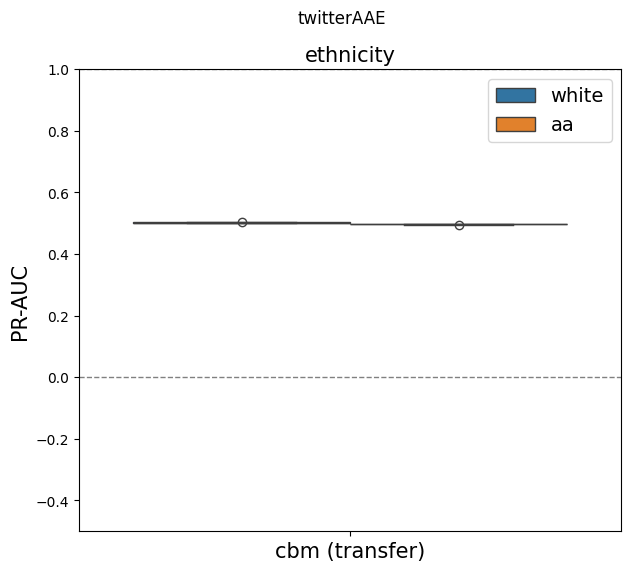

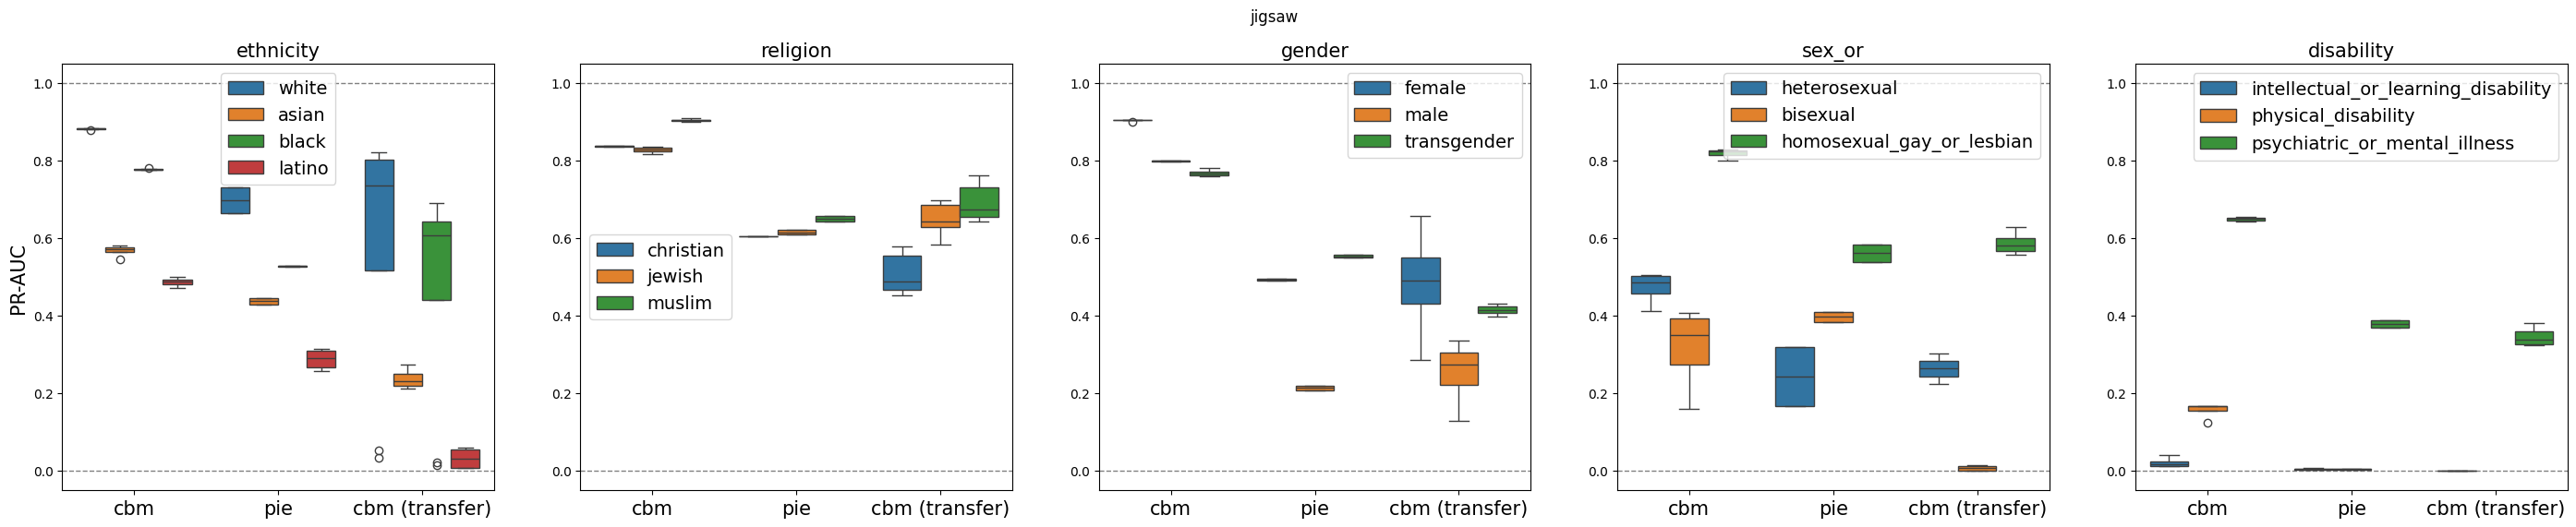

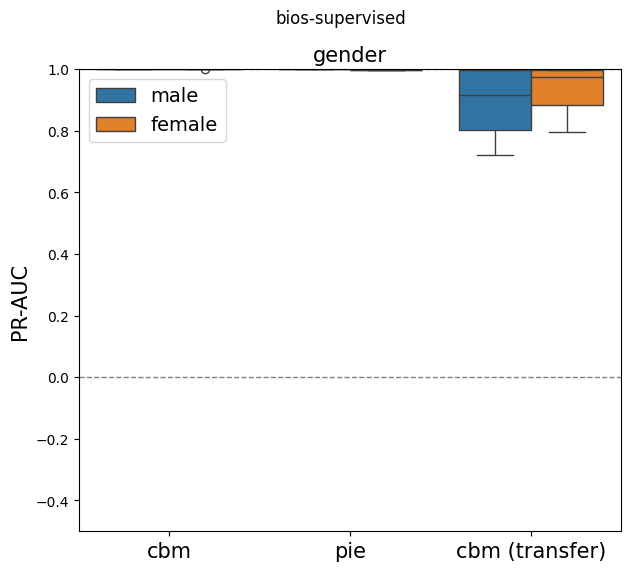

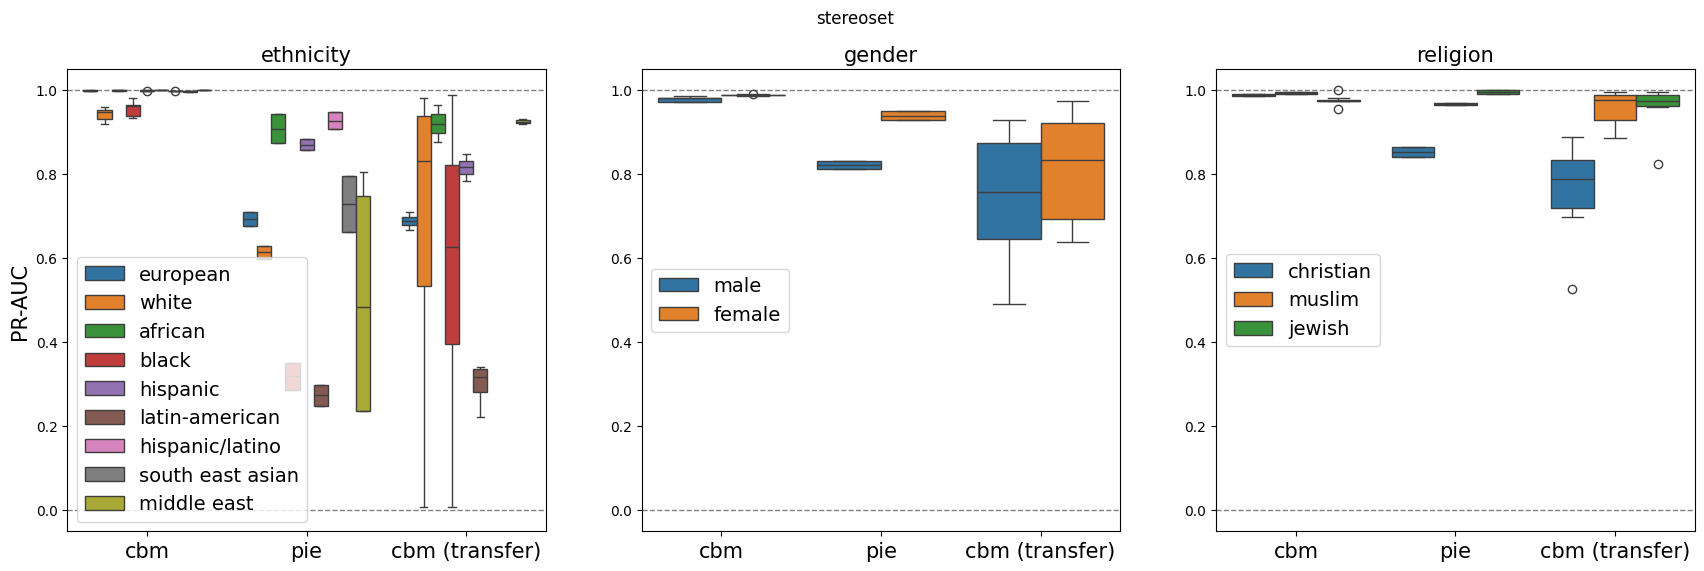

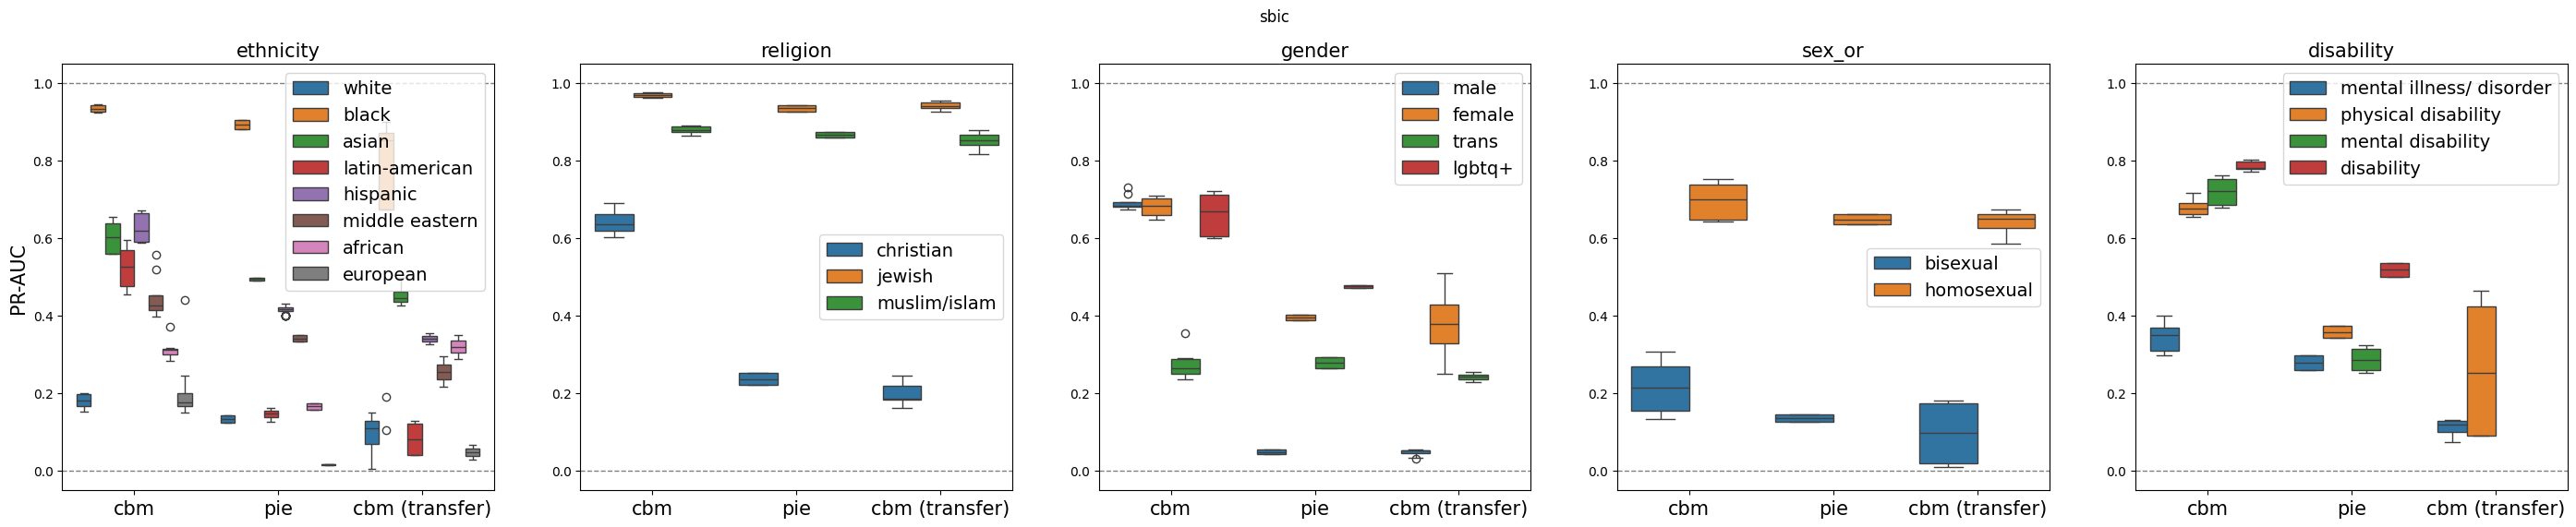

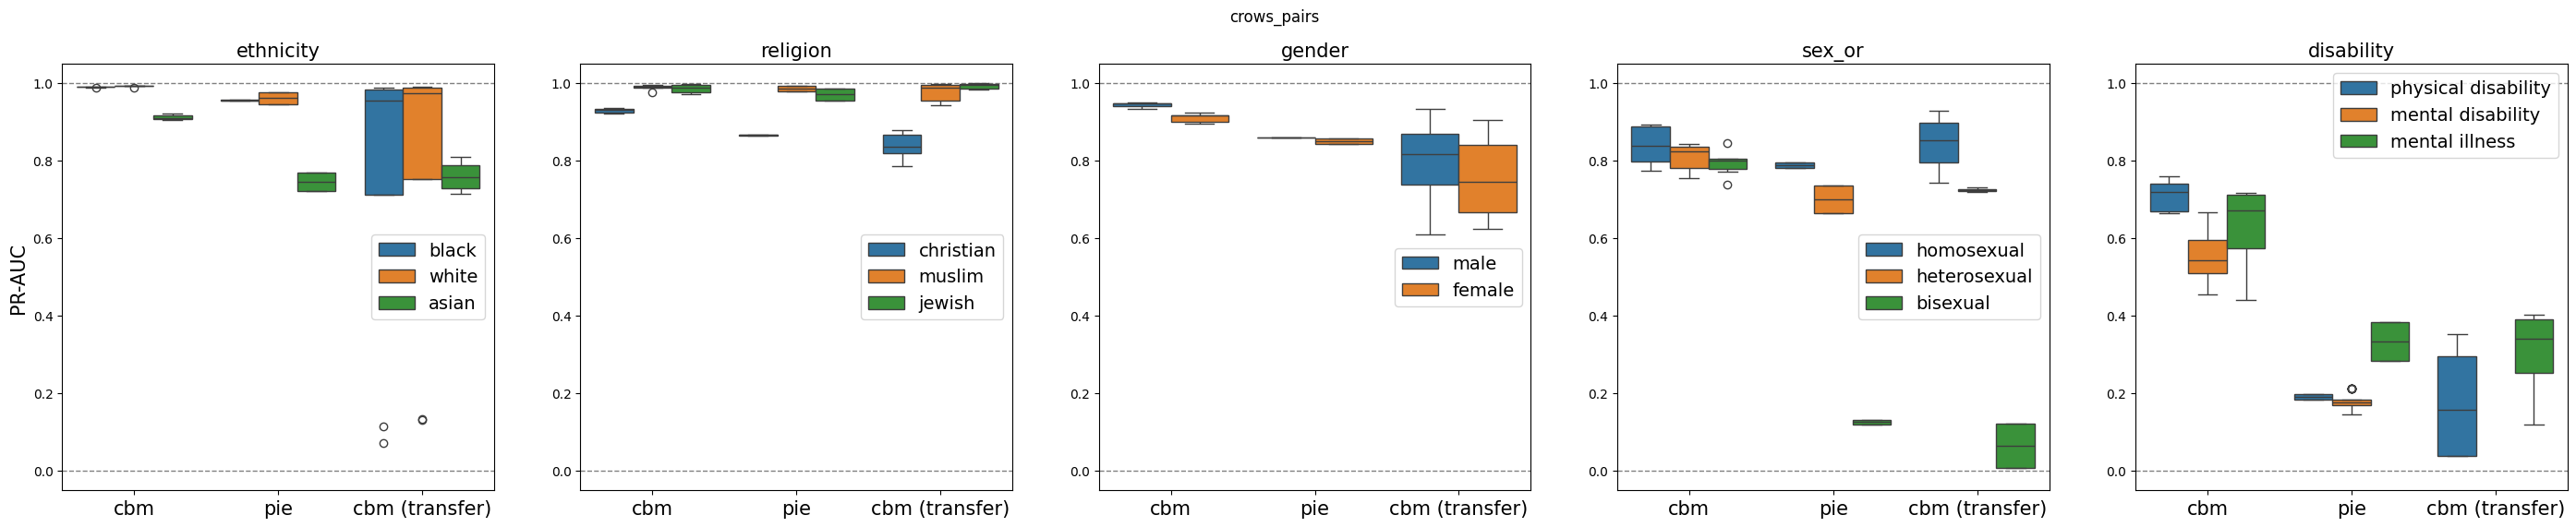

In [114]:
datasets = list(set(res_concept.loc[:,'dataset (test)']))
for dataset in datasets:
    res_concept_ = res_concept[res_concept['dataset (test)'] == dataset]
    multipot(res_concept_, subplot_col='attribute', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False, title=dataset)

### Concept robustness

In [2]:
CONFIG_FILE = 'configs/new/experiment_config.json'
EMB_SIZE_LOOKUP = {'text-embedding-3-small': 1536,
                   'text-embedding-3-large': 3072,
                   'google/electra-base-generator': 256,
                   'albert-base-v2': 768,
                   'distilbert-base-uncased': 768,
                   'gpt2': 768,
                   'bert-base-uncased': 768,
                   'roberta-base': 768,
                   'bert-large-uncased': 1024,
                   'roberta-large': 1024,
                   'gpt2-large': 1280,
                   'google/electra-base-discriminator': 768
                  }

## Setup

In [3]:
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)

openai_models = config["openai_models"]
huggingface_models = config["huggingface_models"]
models = huggingface_models + openai_models

In [4]:
results_cav = pd.read_csv('../'+config['results_dir']+config['cav_results_file'])
results_cbm = pd.read_csv('../'+config['results_dir']+config['cbm_results_file'])
results_bias_space = pd.read_csv('../'+config['results_dir']+config['bias_space_results_file'])

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/results/new/cav_feature_eval.csv'

In [ ]:
assert (results_cav.columns == results_cbm.columns).all() and (results_cav.columns == results_bias_space.columns).all()

In [ ]:
results_cav

In [ ]:
results_cbm

In [ ]:
results_bias_space

## Process results

In [ ]:
# set concept method
res_bias_space = results_bias_space.copy()
res_bias_space['method'] = 'bias space'
res_cav = results_cav.copy()
res_cav['method'] = 'CAV'
res_cbm = results_cbm.copy()
res_cbm['method'] = 'CBM'

# merge results
res_all = pd.concat([res_bias_space, res_cav, res_cbm])
res_all = res_all.reset_index()

# fill empty pooling cells (openai models)
res_all.loc[:,'pooling'] = res_all.loc[:,'pooling'].fillna('unknown')

In [ ]:
def get_pretrained_model(model_name, n_classes, batch_size=1, pooling='mean', multi_label=False):    
    if multi_label: 
        lm = BertHuggingface(n_classes, model_name=model_name, batch_size=batch_size, pooling=pooling, loss_function=torch.nn.BCEWithLogitsLoss)
    else:
        lm = BertHuggingface(n_classes, model_name=model_name, batch_size=batch_size, pooling=pooling)
    return lm

def get_model_architecture(model_name):
    if type(model_name) != str:
        return model_name
        
    if model_name in openai_models:
        return 'embedder' # presumably also encoder based
    if 'gpt' in model_name:
        return 'decoder'
    else:
        return 'encoder'

def get_model_type(model_name):
    if type(model_name) != str:
        return model_name
        
    if model_name in openai_models:
        return 'embedder'
    if 'gpt' in model_name or 'generator' in model_name:
        return 'generator'
    else:
        return 'discriminator'

res_all['model_type'] = [get_model_type(res_all.loc[i,'embedder']) for i in range(len(res_all))]
res_all['model_architecture'] = [get_model_architecture(res_all.loc[i,'embedder']) for i in range(len(res_all))]

def get_emb_size(model_name):
    # check model's emb size is saved in the lookup
    if not model_name in EMB_SIZE_LOOKUP.keys():
        if model_name in huggingface_models:
            # load model and get size
            lm = get_pretrained_model(model_name, 2, batch_size=1)
            EMB_SIZE_LOOKUP[model_name] = lm.model.config.hidden_size
        else:
            print("cannot query model size for %s, which is not in the list of huggingface models (set size to 0)")
            EMB_SIZE_LOOKUP[model_name] = 0

    return EMB_SIZE_LOOKUP[model_name]

res_all['emb_size'] = [get_emb_size(res_all.loc[i,'embedder']) for i in range(len(res_all))]
res_all

In [ ]:
# from a western-centric perspective (leaving white,male,christian as non-marginalized groups)
marginalized_groups = ['F', 'female', 'asian', 'black', 'latino', 'buddhist', 'hindu', 'jewish', 'muslim', 'mental_disability_illness', 'psychiatric_or_mental_illness']

# from a western/ US perspective / groups that appear infrequent in the datasets (TODO confirm and provide than threshold)
minority_groups = ['asian', 'latino', 'buddhist', 'hindu', 'mental_disability_illness', 'psychiatric_or_mental_illness']


## Utils

In [27]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

In [38]:
def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0):
    # mark 0 with hline
    ax.hlines(y=0, xmin=-1, xmax=6, linewidth=0.5, color='black')

    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        sns.boxplot(data=res_dataset, x=xcol, y=ycol, ax=ax)

    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=15)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=15)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    legend = ax.legend(fontsize=14)
    if remove_legend:
        legend.remove()

def multipot(results, subplot_col, xcol, ycol, huecol, title=None, remove_legend=False, savefile=None):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(5*len(subplot_choices), 4))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0))
    if title is not None:
        plt.suptitle(title)
    
    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

## 1) Baseline: Linear Concept learning (CAV, CBM)

Report and plot F1-scores for CAV and CBM in the regular concept learning (train-test from same datasets) and concept transfer (to another dataset) setting. The concept learning serves as a baseline as it should reflect the best possible estimation of linear concepts in the language model's embeddings (assuming classifiers converge; given the available data). The concept transfer case shows how robust or dataset-specific the learned concepts are.

### a) Learning and testing on splits of the same dataset

In [29]:
res_cl = res_all[res_all['method'] != 'bias space']

# aggregate results of all groups of the same experiment run
gres = aggregate_results(res_cl, ['method', 'protected_attr', 'dataset (train)', 'dataset (eval)', 'pooling', 'embedder'], 'F1')

# add column to distinguish transfer and non-transfer cases
gres.loc[:, 'exp'] = ['transfer' if gres.loc[i, 'dataset (train)'] != gres.loc[i, 'dataset (eval)'] else '' for i in range(len(gres))]
gres_same_dataset = gres[gres['exp'] != 'transfer']

# summarize results per dataset and transfer/ non transfer
res_per_dataset_transfer = aggregate_results(gres_same_dataset, ['exp', 'dataset (eval)', 'method'], 'F1')
res_per_dataset_transfer

,index,exp,dataset (eval),method,F1,F1 var
0,0,,bios-supervised,CAV,0.697755,1.109690e-02
1,1,,bios-supervised,CBM,0.995126,NaN
2,2,,crows_pairs,CAV,0.884552,6.539727e-03
3,3,,jigsaw,CAV,0.454903,4.483747e-02
4,4,,jigsaw,CBM,0.003897,6.239591e-07
5,5,,stereoset,CAV,0.604141,9.739675e-03


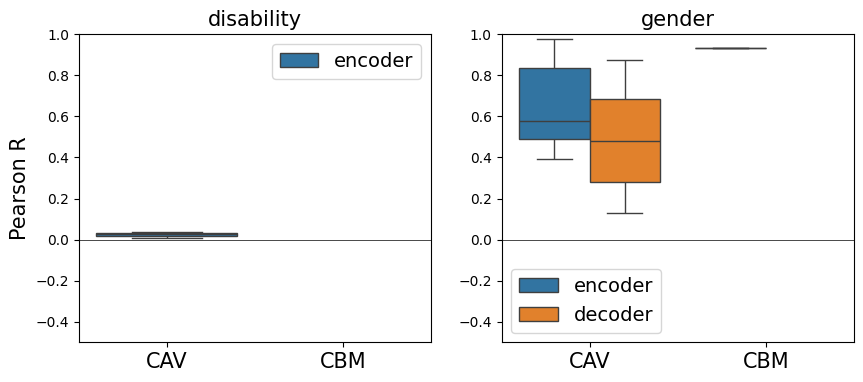

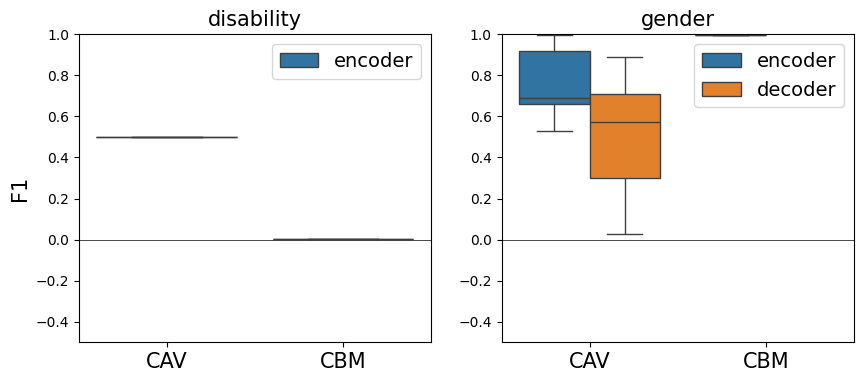

In [30]:
res_cl_same_dataset = res_cl[res_cl['dataset (train)'] == res_cl['dataset (eval)']]

multipot(res_cl_same_dataset, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False)
multipot(res_cl_same_dataset, subplot_col='protected_attr', xcol='method', ycol='F1', huecol='model_architecture', remove_legend=False)

### b) Cross-dataset transfer

In [31]:
gres_transfer = gres[gres['exp'] == 'transfer']

# summarize results per dataset and transfer/ non transfer
res_per_dataset_transfer = aggregate_results(gres_transfer, ['exp', 'dataset (eval)', 'method'], 'F1')
res_per_dataset_transfer

,index,exp,dataset (eval),method,F1,F1 var
0,0,transfer,bios-supervised,CAV,0.421163,0.088879
1,1,transfer,crows_pairs,CAV,0.429459,0.022005
2,2,transfer,crows_pairs,CBM,0.003545,0.000003
3,3,transfer,jigsaw,CAV,0.252827,0.019702
4,4,transfer,stereoset,CAV,0.253050,0.019898


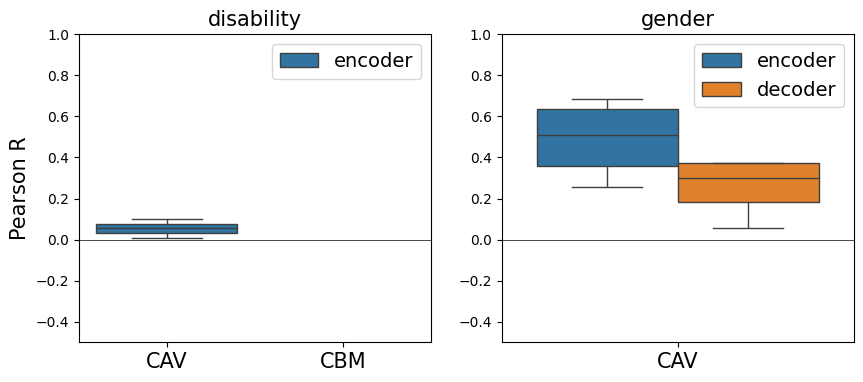

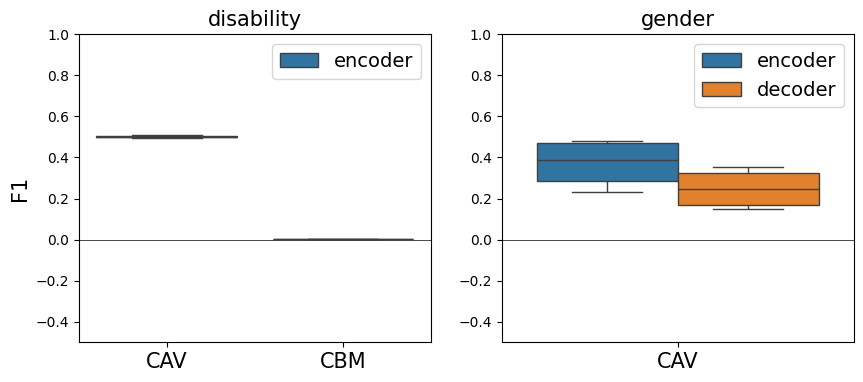

In [32]:
res_cl_transfer = res_cl[res_cl['dataset (train)'] != res_cl['dataset (eval)']]

# aggregate results over dataset first (bc number of rows/ protected groups is different!)
grouped_res_r = res_cl_transfer.groupby(['protected_attr', 'dataset (eval)', 'method', 'model_type','model_architecture'], as_index=False)['Pearson R'].mean().reset_index()
multipot(grouped_res_r, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False)

grouped_res_f1 = res_cl_transfer.groupby(['protected_attr', 'dataset (eval)', 'method', 'model_type','model_architecture'], as_index=False)['F1'].mean().reset_index()
multipot(grouped_res_f1, subplot_col='protected_attr', xcol='method', ycol='F1', huecol='model_architecture', remove_legend=False)

## 2) Evaluating Bias Space for Concept Retrieval

Comparing Pearson Correlation of Bias Space concepts with CBM and CAV.

### a) Overview over protected attributes.

In [33]:
res_all.columns

Index(['index', 'protected_attr', 'dataset (train)', 'dataset (eval)',
       'embedder', 'pooling', 'group (test)', 'concept (train)', 'F1',
       'Pearson R', 'Pearson p', 'method', 'model_type', 'model_architecture',
       'emb_size'],
      dtype='object')

In [34]:
# aggregate results over groups of the same experiment setup
gres = aggregate_results(res_all, ['protected_attr', 'dataset (train)', 'dataset (eval)', 'embedder', 'pooling', 'method', 'model_architecture', 'model_type', 'emb_size'], 'Pearson R')

In [35]:
gres_same_dataset = gres[(gres['method'] == 'bias space') | (gres['dataset (train)'] == gres['dataset (eval)'])]
gres_transfer = gres[(gres['method'] == 'bias space') | (gres['dataset (train)'] != gres['dataset (eval)'])]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


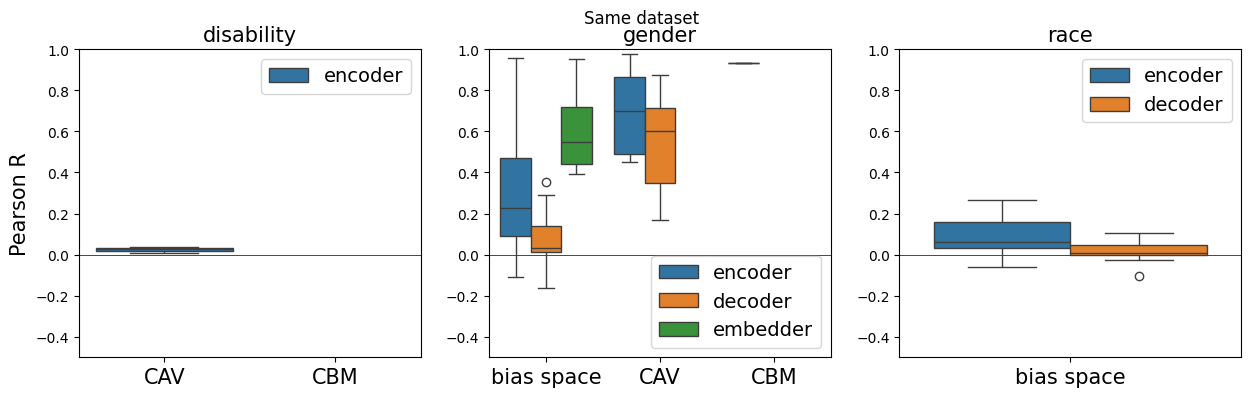

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


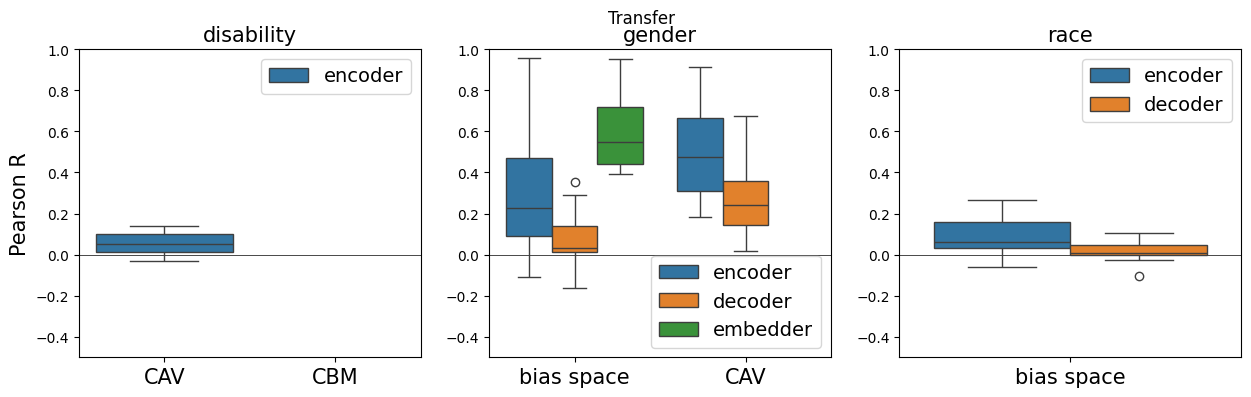

In [39]:
multipot(gres_same_dataset, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', title='Same dataset', remove_legend=False, savefile='plots/esann25/corr.eps')
multipot(gres_transfer, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', title='Transfer', remove_legend=False, savefile='plots/esann25/corr.eps')

### b) Overview over datasets (one plot per attribute)


gender


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


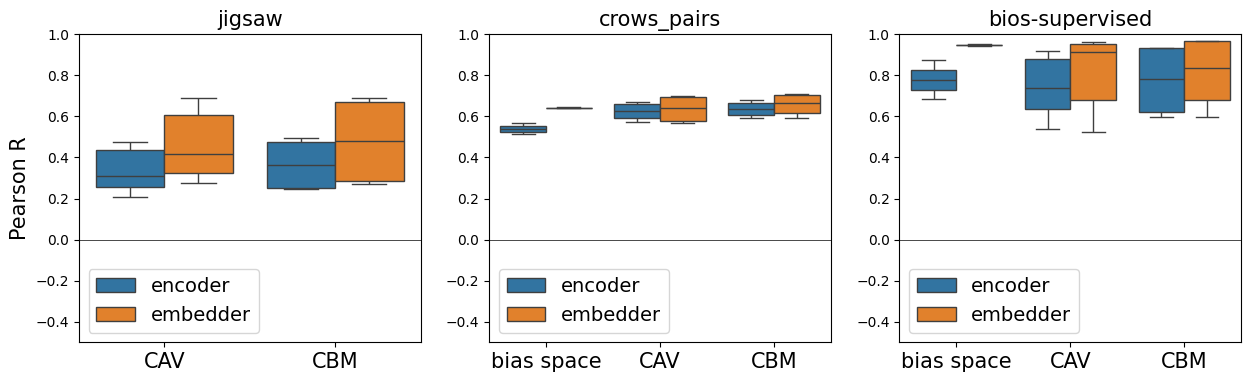


race


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


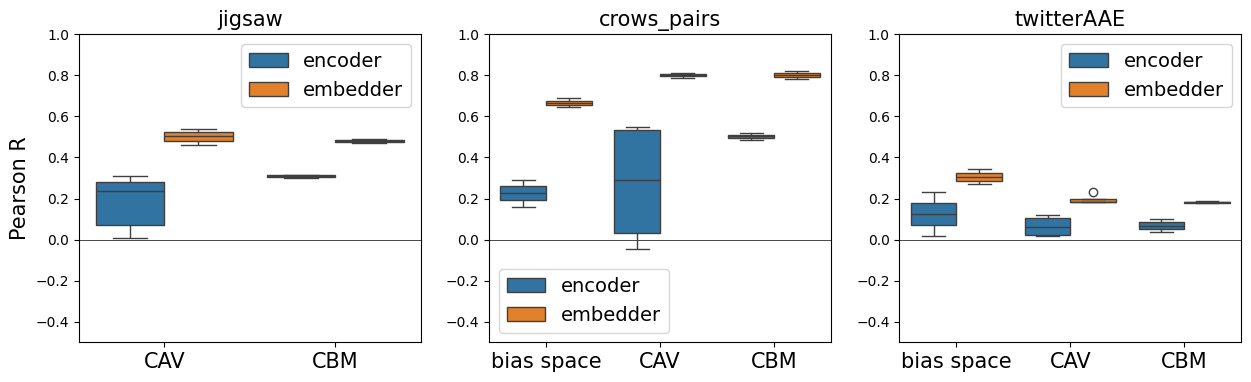

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



religion


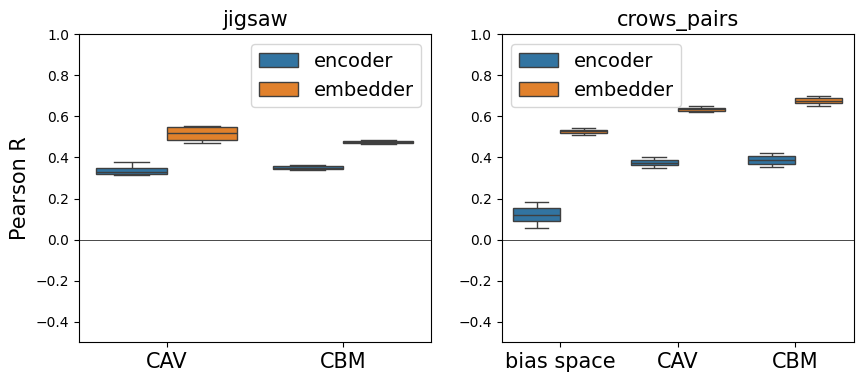

In [37]:
protected_attr = list(set(gres['protected_attr']))
for attr in protected_attr:
    print()
    print(attr)
    res_filt = gres[gres['protected_attr'] == attr]
    multipot(res_filt, subplot_col='dataset (eval)', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False, savefile=('plots/esann25/corr_%s.eps' % attr))